### Realize simple NNet with Tensorflow on MNIST dataset
baselines:

0) Custom Logistic Regressison (TF in-class) ~ 0.9086 (9%)

Need to achived:  Accuracy 0.9840 (Error Rate 1,6%)

http://yann.lecun.com/exdb/mnist/

1) 2-layer NN, 300 HU, 1998, Y. LeCun

2) 2-layer NN, 800 HU, 2003, P. Simard


In [1]:
import sys
print(sys.version)

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
print('tensorflow',tf.__version__)

sess = tf.InteractiveSession() 
devices = sess.list_devices()
for d in devices:
    print(d.name)
sess.close()

import datetime, time

from matplotlib import pyplot as plt
# %pylab inline

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
tensorflow 1.12.0
/job:localhost/replica:0/task:0/device:CPU:0


In [2]:
def load_dataset(val_prop = 1/6, normalize = True, flatten = False):
    '''function from hse-class (utility 7/10) - extended'''
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # normalize input matrix
    if normalize:
        X_train = X_train.astype(float) / 255.
        X_test = X_test.astype(float) / 255.

    # train-validation partitioning
    PROP_VALUE = int(round(X_train.shape[0]*val_prop,0))
    X_train, X_val = X_train[:-PROP_VALUE], X_train[-PROP_VALUE:]
    
    # make OHE-trasformation for target
    def np_ohe(x, uniq):
        return np.array([(x == i)*1 for i in uniq]).T
    
    y_train = np_ohe(y_train, np.unique(y_train).tolist())
    y_train, y_val = y_train[:-PROP_VALUE], y_train[-PROP_VALUE:]
    y_test = np_ohe(y_test, np.unique(y_test).tolist())
    
    if flatten: 
        X_train = X_train.reshape(-1,28**2)
        X_val = X_val.reshape(-1,28**2)
        X_test = X_test.reshape(-1,28**2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten = True)

In [3]:
print('X: train, val, test',X_train.shape,X_val.shape,X_test.shape,sep='\n')
print('y: train, val, test',y_train.shape,y_val.shape,y_test.shape,sep='\n')

X: train, val, test
(50000, 784)
(10000, 784)
(10000, 784)
y: train, val, test
(50000, 10)
(10000, 10)
(10000, 10)


Number: 5


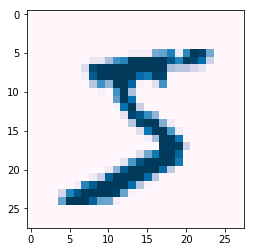

In [4]:
print('Number:',np.argmax(y_train[0]))
plt.imshow(X_train[0].reshape(28,28), cmap='PuBu');

In [5]:
# NOTES (How to make custom layers - maybe way)

# # 
# def fullyconnected_layer(x, input_size, out_size):
#     W = tf.Variable(tf.truncated_normal([input_size, out_size], stddev=0.1))
#     b = tf.Variable(tf.truncated_normal([out_size], stddev=0.1))
#     return tf.nn.relu(tf.matmul(x,W) + b)
# # 
# def softmax_layer(x, input_size, out_size):
#     W = tf.Variable(tf.truncated_normal([input_size, out_size], stddev=0.1))
#     b = tf.Variable(tf.truncated_normal([out_size], stddev=0.1))
#     return tf.nn.softmax(tf.matmul(x,W) + b)
# # 

...

In [6]:
# Use someone else's code to achieve their goals. (c) Unknown Programmer

from IPython import display

def visualize(l1,l2, h1, h2):
    '''function from hse-class (utility 10/10)'''
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()
    
# for branch approach (use later)
def batches_generator(X, y, batch_size):
    '''function from hse-class (utility 8/10)'''
    n_batches = int(X.shape[0]/batch_size) + 1
    for batch_idx in range(n_batches):
        indices = (batch_idx*batch_size, min(X.shape[0], (batch_idx+1)*batch_size))
        yield X[indices[0]:indices[1]], y[indices[0]:indices[1]]


In [7]:
with tf.Session():
    a = tf.constant([[5,3],[4,1]])
    b = tf.constant([2,1])
    c1 = a*b
    c2 = b*a
    print(c1.eval())
    print(c2.eval())

[[10  3]
 [ 8  1]]
[[10  3]
 [ 8  1]]


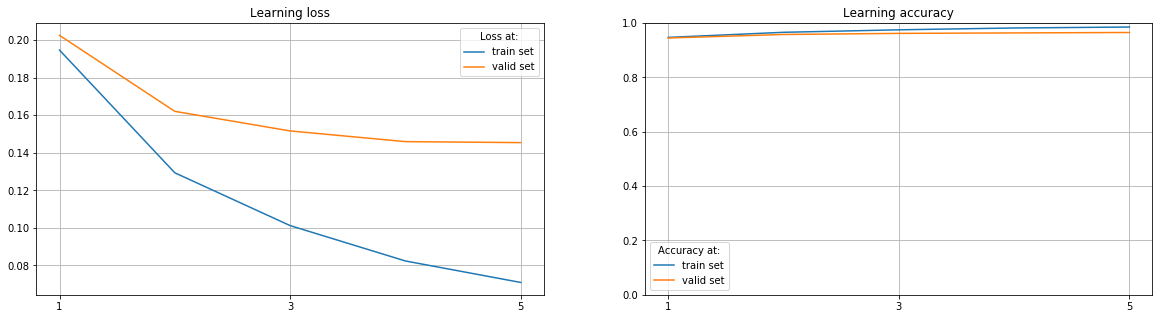

Accuracy (test): 0.9629
Model saved in path: C:\Users\johnwhite\Documents\hseML\HSEML\ANNet\homework\hw02\tmp\model.ckpt
Time eval 0:00:25.053808


In [8]:
# MY SWEET BLOODY CODE

# ------------------------------------------------------------------------------------------
# MAKE GRAPH
# ------------------------------------------------------------------------------------------

# SHAPE_AND_HIDDEN_UNITS
IN_, OUT_ = X_train.shape[1], y_train.shape[1]
HU1, HU2 = 200, 200

INPUT_ = tf.placeholder(dtype='float32',shape=( None, IN_ ))
OUTPUT_ = tf.placeholder(dtype='float32',shape=( None, OUT_ ))

# ------------------------------------------------------------------------------------------

# BATCH_NORMAL_INPUT_LAYER
SCL_0 = tf.Variable(tf.ones([IN_]))
SHF_0 = tf.Variable(tf.zeros([IN_]))
MOM_0 = tf.nn.moments(INPUT_, axes=[0])
BAT_0 = SCL_0*(INPUT_ - MOM_0[0])/(tf.sqrt(MOM_0[1])+1e-8) + SHF_0

# ------------------------------------------------------------------------------------------

# RELU_ACTIV_LAYER_1(INPUT_LAYER)
W1 = tf.Variable(tf.truncated_normal([ IN_, HU1 ], stddev=0.1))
B1 = tf.Variable(tf.truncated_normal([ HU1 ], stddev=0.1))
L1 = tf.nn.relu(tf.matmul( BAT_0 , W1 ) + B1 )

# # BATCH_NORMAL_OUT_LAYER_1
# SCL_1 = tf.Variable(tf.random_uniform([HU1]))
# SHF_1 = tf.Variable(tf.random_uniform([HU1]))
# MOM_1 = tf.nn.moments(L1, axes=[0])
# BAT_1 = SCL_1*(L1 - MOM_1[0])/(tf.sqrt(MOM_1[1]) + 1e-8) + SHF_1

# ------------------------------------------------------------------------------------------

# RELU_ACTIV_LAYER_2(OUT_LAYER_1)
W2 = tf.Variable(tf.truncated_normal([ HU1, HU2 ], stddev=0.1))
B2 = tf.Variable(tf.truncated_normal([ HU2 ], stddev=0.1))
L2 = tf.nn.relu(tf.matmul( L1, W2 ) + B2)

# # BATCH_NORMAL_OUT_LAYER_2
# SCL_2 = tf.Variable(tf.random_uniform([HU2]))
# SHF_2 = tf.Variable(tf.random_uniform([HU2]))
# MOM_2 = tf.nn.moments(L2, axes=[0])
# BAT_2 = SCL_2*(L2 - MOM_2[0])/(tf.sqrt(MOM_2[1])+1e-8) + SHF_2

# ------------------------------------------------------------------------------------------

# SOFTMAX_ACTIV_PREDICT_LAYER(OUT_LAYER_2)
W3 = tf.Variable(tf.truncated_normal([ HU2, OUT_ ], stddev=0.1))
B3 = tf.Variable(tf.truncated_normal([ OUT_ ], stddev=0.1))
L3 = tf.nn.softmax(tf.matmul( L2, W3 ) + B3)

# ------------------------------------------------------------------------------------------

# LOSS FUNCTION
LOSS = tf.reduce_mean(-tf.reduce_sum(OUTPUT_*tf.log(L3+1e-8), reduction_indices=1)) 

# QUALITY METRICS
PREDICT = tf.equal(tf.argmax(L3, 1), tf.argmax(OUTPUT_, 1))
ACCURACY = tf.reduce_mean(tf.cast(PREDICT, tf.float32))

# GRADIENT DESCENT (0.0005, 0.99, 0.99, 1e-6)
OPTIMAZER = tf.train.AdamOptimizer(0.0005).minimize(LOSS, var_list=[W1, B1, W2, B2, W3, B3, 
                                                                   SCL_0, SHF_0])

# SCL_0, SHF_0, SCL_1, SHF_1, SCL_2, SHF_2
# ------------------------------------------------------------------------------------------
## INIT SESSION
# ------------------------------------------------------------------------------------------

np.random.seed(42)   # для воспроизводимости

n_epochs = 5        # число эпох для обучения 
batch_size = 128    # размер одного батча 

sess = tf.InteractiveSession()                 # запускаем сессию для вычислений 
sess.run(tf.global_variables_initializer())    # инициализируем переменные 

saver = tf.train.Saver() # ВАЖНО! Сохраним весь стафф на диск.

# будем писать значения метрик в вектора 
loss_train, loss_val  = [ ], [ ] 
acc_train, acc_val = [ ], [ ]

# ------------------------------------------------------------------------------------------
## RUN GRAPH
# ------------------------------------------------------------------------------------------
start = datetime.datetime.now()

for i in range(n_epochs):
    
    # сгенерировали батчи 
    batch_gen = batches_generator(X_train, y_train, batch_size)
    
    # пошёл цикл по батчам 
    for X_batch, y_batch in batch_gen:
        # итерация градиентного спуска на текущем батче 
        sess.run(OPTIMAZER, {INPUT_: X_batch, OUTPUT_: y_batch})
    
    # посмотрим на качество модели на трэйне и валидации
    loss_train.append(sess.run(LOSS, {INPUT_: X_train, OUTPUT_: y_train}))
    loss_val.append(sess.run(LOSS, {INPUT_: X_val, OUTPUT_: y_val}))
    
    acc_train.append(sess.run(ACCURACY, {INPUT_: X_train, OUTPUT_: y_train}))
    acc_val.append(sess.run(ACCURACY, {INPUT_: X_val, OUTPUT_: y_val}))
    
    # визуализируем
    visualize(loss_train, loss_val, acc_train, acc_val) 

visualize(loss_train, loss_val, acc_train, acc_val) 
print("Accuracy (test): %s" %sess.run(ACCURACY, {INPUT_: X_test, OUTPUT_: y_test}))

from os import getcwd
save_path = saver.save(sess, str(getcwd()) + r"\tmp\model.ckpt")
print("Model saved in path: %s" % save_path)

sess.close()

print ('Time eval', datetime.datetime.now() - start)

In [9]:
sess = tf.InteractiveSession() 
saver.restore(sess, str(getcwd()) + r"\tmp\model.ckpt")
print("Computational graph upload.")
print("Accuracy (test): %s" %sess.run(ACCURACY, {INPUT_: X_test, OUTPUT_: y_test}),'(restored)')
sess.close()

INFO:tensorflow:Restoring parameters from C:\Users\johnwhite\Documents\hseML\HSEML\ANNet\homework\hw02\tmp\model.ckpt
Computational graph upload.
Accuracy (test): 0.9629 (restored)


In [ ]:
## xgboost baseline - without cv, param. opt. & etc.

In [ ]:
import xgboost as xgb

In [ ]:
(X_dtrain, y_dtrain), (X_dtest, y_dtest) = mnist.load_data()

X_dtrain = X_dtrain.reshape(-1,28*28) / 255
X_dtest = X_dtest.reshape(-1,28*28) / 255

print('X: train, test',X_dtrain.shape, X_dtest.shape,sep='\n')
print('y: train, test',y_dtrain.shape, y_dtest.shape,sep='\n')

In [ ]:
dtrain = xgb.DMatrix(X_dtrain, label = y_dtrain)
dtest = xgb.DMatrix(X_dtest, label = y_dtest)

In [ ]:
xgb_params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'eta': 0.5,
    'gamma' : 0,
    'booster': 'gbtree',
    
    'alpha': 1.0,
    'lambda': 0.1,
    
    'subsample': 0.3,
    'colsample_bytree': 0.3,
    'colsample_bylevel': 1.0,
    
    'min_child_weight': 1,
    'silent': 1,
    'seed': 1,
    'nthread': 4,
    'eval_metric': 'mlogloss',
    'num_class': 10    
}

num_rounds = 100

In [ ]:
start = datetime.datetime.now()

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
eval_res ={}
gbdt = xgb.train(xgb_params, dtrain,
                 num_rounds, watchlist,
                 early_stopping_rounds=5,
                 verbose_eval=10,
                 evals_result=eval_res)

print(datetime.datetime.now() - start)

In [ ]:
print('Accuracy XGB:',np.mean(gbdt.predict(dtest) == y_dtest),'Хорошо. Можно дотюнить. Но относительно долго...')